# Профилирование и оптимизация вычислений Dask

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Dask"
* https://docs.dask.org/en/stable/diagnostics-local.html#profiler
* https://docs.dask.org/en/stable/diagnostics-local.html#progress-bar
* https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.broken_barh.html
* https://docs.python.org/3/library/stdtypes.html#str.rsplit
* https://docs.dask.org/en/stable/api.html#dask.datasets.make_people
* https://docs.dask.org/en/stable/scheduling.html
* https://distributed.dask.org/en/stable/client.html

## Задачи для совместного разбора

In [3]:
!pip install dask==2023.3.2
!pip install distributed==2023.3.2

  Using cached dask-2023.3.2-py3-none-any.whl (1.2 MB)
  Attempting uninstall: dask
    Found existing installation: dask 2023.4.1
    Uninstalling dask-2023.4.1:
      Successfully uninstalled dask-2023.4.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires dask==2022.7.0, but you have dask 2023.3.2 which is incompatible.


     -------------------------------------- 956.9/956.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: distributed
    Found existing installation: distributed 2022.7.0
    Uninstalling distributed-2022.7.0:
      Successfully uninstalled distributed-2022.7.0


1\. Создайте массив целых чисел. Вычислите среднее значение элементов. Для демонстрации прогресса используйте ProgressBar. Модифицируйте ProgressBar.

In [1]:
import dask.array as da
from dask.diagnostics import ProgressBar

a = da.random.randint(0, 100, size=(100000, 10000))

In [2]:
a.mean().compute()

49.501084288

In [3]:
with ProgressBar():
    a.mean().compute()

[########################################] | 100% Completed | 1.11 sms


In [4]:
import contextlib

class MyProgressBar(ProgressBar):
    def __init__(self, char: str='#'):
        self.char = char
        #assert len(self.char) == 1, 'Char should have len=1'
        super().__init__()
        
    def _draw_bar(self, frac, elapsed):
        from dask.utils import format_time

        bar = self.char * int(self._width * frac)
        percent = int(100 * frac)
        elapsed = format_time(elapsed)
        msg = "\r[{0:<{1}}] | {2}% Completed | {3}".format(
            bar, self._width, percent, elapsed
        )
        with contextlib.suppress(ValueError):
            if self._file is not None:
                self._file.write(msg)
                self._file.flush()

In [5]:
with MyProgressBar(char='%'):
    a.mean().compute()

[%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%] | 100% Completed | 1.08 sms


2\. Отберите строки, сумма элементов которых является четной. Вычислите среднее значение полученного массива, используя различные планировщики. 

In [6]:
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

In [7]:
b

dask.array<getitem_variadic, shape=(nan, 10000), dtype=int32, chunksize=(nan, 5792), chunktype=numpy.ndarray>

In [8]:
%%time
b.mean().compute(scheduler='threads')

Wall time: 1.22 s


49.49955555019887

In [9]:
%%time
b.mean().compute(scheduler='processes')

OSError: [WinError 1450] Недостаточно системных ресурсов для завершения операции

In [10]:
%%time
b.mean().compute(scheduler='sync')

Wall time: 9.07 s


49.49955555019887

3\. Изучите, как влияет вызов persist на скорость вычислений максимума и среднего значения элементов массива из предыдущей задачи.

In [11]:
import dask

In [12]:
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

In [13]:
%%time
mx = b.max()
avg = b.mean()

print(
    dask.compute(mx, avg)
)

(99, 49.50089128531158)
Wall time: 1.44 s


In [14]:
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask].persist()

In [15]:
mx = b.max()
avg = b.mean()

In [16]:
%%time
print(
    mx.compute(),
    avg.compute()
)

99 49.49917165858934
Wall time: 113 ms


4\. Изучите основные возможности Client на примере предыдущей задачи.

In [17]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 15.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62707,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.95 GiB
Comm: tcp://127.0.0.1:62735,Total threads: 4
Dashboard: http://127.0.0.1:62739/status,Memory: 3.99 GiB
Nanny: tcp://127.0.0.1:62710,


In [18]:
import dask.array as da
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

In [19]:
b.mean().compute()

49.498437114599184

In [20]:
%%time
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask].persist()

Wall time: 33 ms


In [21]:
a = da.random.randint(0, 100, size=(10000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

In [22]:
%%time

b.mean().compute()

Wall time: 716 ms


49.49830876156724

In [23]:
%%time

f = client.compute(b.mean())
f

Wall time: 6.22 ms


<Future: pending, key: finalize-6113c6a00feeac09d3d2c6c5a9256e39>

In [24]:
a = da.random.randint(0, 100, size=(10000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

In [25]:
%%time

f = client.compute(b.mean())
f

Wall time: 7.51 ms


<Future: pending, key: finalize-c8ddfae16dd3bbb31a5342f487930a8f>

## Лабораторная работа 11

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

__Важно: задачи 1-7 решаются без запуска клиента `dask.distributed.Client`__

<p class="task" id="1"></p>

1\. Создайте массив из 1 млн. строк и 256 столбцов, заполненный числами из нормального распределения с $\mu=10$ и $\sigma=5$. При помощи метода `rechunk` сделайте так, чтобы данные были разбиты на сегменты по 250 тыс. строк.

Используя `dask.diagnostics.Profiler`, исследуйте процесс вычисления суммы элементов этого массива. Результат представьте в виде `pd.DataFrame` со столбцами: `key`, `start_time`, `end_time`, `worker_id`, `time_taken` и `task_type`. В поле `key` должны храниться строки - идентификаторы задач. 

В поле `task_type` должны храниться строки - типы задач, которые можно извлечь из `key`. Например, для строки "normal-33a0474c5b5133263153dbd93d8fa610" категорией является "normal", а для строки "rechunk-merge-sum-290d08054ec62d2e1cd1c42b68f" - "rechunk-merge-sum".

Выведите на экран количество задач и количество уникальных типов этих задач

In [1]:
import dask.array as da
import dask.diagnostics as diag

# создание массива
arr = da.random.normal(10, 5, size=(1000000, 256), chunks=(250000, 256))

# вычисление суммы элементов массива
total_sum = arr.sum()

# запуск профилировщика
with diag.Profiler() as prof:
    result = total_sum.compute()

In [2]:
import pandas as pd

# извлечение данных из профилировщика
data = []
for task in prof.results:
    data.append({
        "key": str(task.key),
        "start_time": task.start_time,
        "end_time": task.end_time,
        "worker_id": task.worker_id,
        "time_taken": task.end_time - task.start_time,
        "task_type": str(task.key).rsplit("-", 1)[0][2:]
    })

# создание DataFrame
df = pd.DataFrame(data)

# вывод количества задач и типов задач
print(f"Number of tasks: {len(df)}")
print(f"Number of task types: {len(df['task_type'].unique())}")

Number of tasks: 11
Number of task types: 4


In [3]:
df

,key,start_time,end_time,worker_id,time_taken,task_type
0,('normal-sum-314f0cbd4c1e34db1039d0f524b2d454'...,2.935451,4.330381,2764,1.394929,normal-sum
1,('normal-sum-314f0cbd4c1e34db1039d0f524b2d454'...,2.935458,4.474109,10584,1.538651,normal-sum
2,('normal-sum-314f0cbd4c1e34db1039d0f524b2d454'...,2.935462,4.524609,8628,1.589147,normal-sum
3,('normal-sum-314f0cbd4c1e34db1039d0f524b2d454'...,2.935467,4.384951,11864,1.449485,normal-sum
4,"('sum-314f0cbd4c1e34db1039d0f524b2d454', 0, 0)",4.330423,4.330858,2764,0.000435,sum
5,"('sum-314f0cbd4c1e34db1039d0f524b2d454', 3, 0)",4.384977,4.385438,2764,0.000461,sum
6,"('sum-314f0cbd4c1e34db1039d0f524b2d454', 1, 0)",4.474144,4.474464,2764,0.000320,sum
7,('sum-partial-c7197aa7bbd3343f4da72caef198299a...,4.474471,4.475039,10584,0.000569,sum-partial
8,"('sum-314f0cbd4c1e34db1039d0f524b2d454', 2, 0)",4.524631,4.524984,11864,0.000353,sum
9,('sum-partial-c7197aa7bbd3343f4da72caef198299a...,4.524992,4.525482,2764,0.000490,sum-partial


<p class="task" id="2"></p>

2\. Профайлер `dask.diagnostics.Profiler` возвращает временные метки `start_time` и `end_time`, начиная с момента запуска ядра ноутбука. Напишите собственную версию профайлера `ProfilerWithInitialTimestamp`, который возвращает результаты замеров времени, начиная с момента запуска ячейки. Результат представьте в виде `pd.DataFrame` со столбцами: `key`, `start_time`, `end_time`, `worker_id`, `time_taken` и `task_type` аналогично заданию 1. Выведите на экран минимум и максимум по столбцу `start_time`.

In [5]:
import dask.diagnostics as diag
import pandas as pd
import time

class ProfilerWithInitialTimestamp(diag.Profiler):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._start_time = time.monotonic()

    def _now(self):
        return time.monotonic() - self._start_time

In [6]:
arr = da.random.normal(10, 5, size=(1000000, 256), chunks=(250000, 256))

In [7]:
total_sum = arr.sum()

In [8]:
with ProfilerWithInitialTimestamp() as prof:
    result = total_sum.compute()

In [9]:
data = []
for task in prof.results:
    data.append({
        "key": str(task.key),
        "start_time": task.start_time,
        "end_time": task.end_time,
        "worker_id": task.worker_id,
        "time_taken": task.end_time - task.start_time,
        "task_type": str(task.key).rsplit("-", 1)[0][2:]
    })

In [10]:
df = pd.DataFrame(data)

In [11]:
print(f"Minimum start time: {df['start_time'].min()}")
print(f"Maximum start time: {df['start_time'].max()}")

Minimum start time: 16.1274944
Maximum start time: 18.1181255


In [12]:
print(f"Number of tasks: {len(df)}")
print(f"Number of task types: {len(df['task_type'].unique())}")

Number of tasks: 11
Number of task types: 4


<p class="task" id="3"></p>

3\. Визуализируйте процесс вычислений в виде горизонтальных столбчатых диаграмм с разрывами. По горизонтальной оси откладывается время, по вертикальной - номер задачи. Каждая задача располагается по вертикали на высоте, соответствующей своему номеру. Ширина столбца (по горизонтали) соответствует продолжительности выполнения задачи. Цвет столбца соответствует типу задачи. Каждый столбик должен иметь подпись, состояющую из нескольких первых символов идентификатора задачи.

Примерный вид итоговой визуализации:
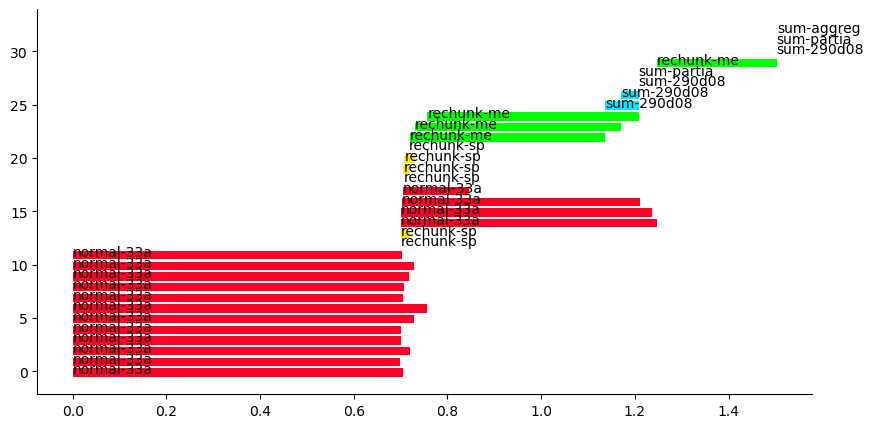

По лоигике, данная визуализация должна работать корректно, но не хватает масштаба для графика (видно не всю информацию, которая есть на графике)

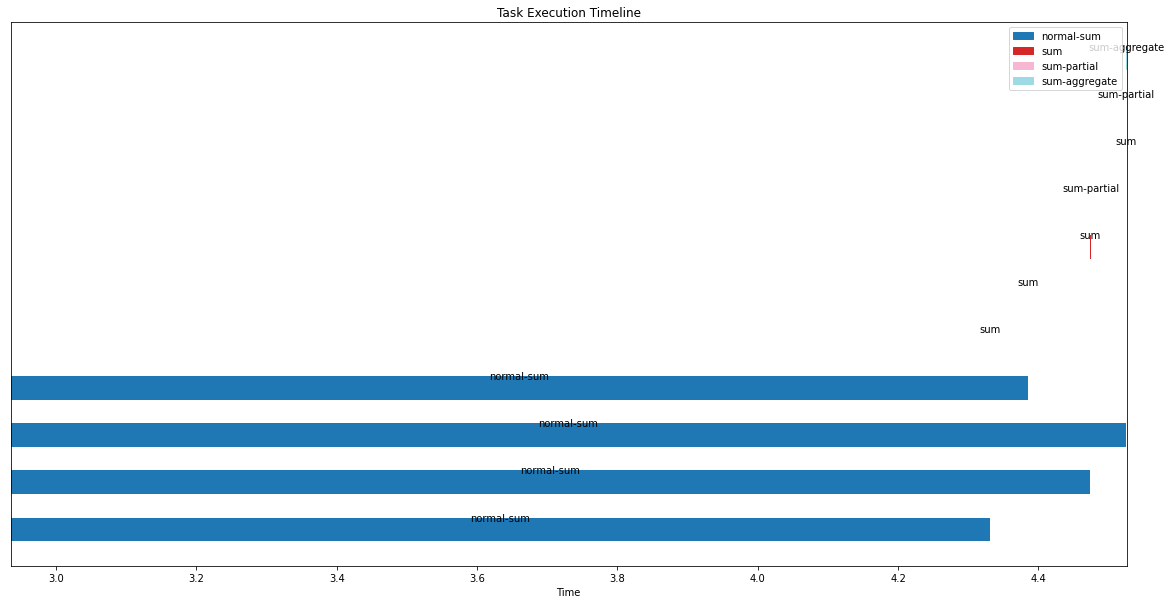

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# определяем уникальные типы задач
task_types = df['task_type'].unique()

# создаем цветовую палитру для типов задач
colors = plt.cm.get_cmap('tab20', len(task_types))

# создаем фигуру и оси для диаграммы
fig, ax = plt.subplots(figsize=(20, 10))

# отключаем ось Y
ax.get_yaxis().set_visible(False)

# отображаем каждую задачу в виде столбца
for i, row in df.iterrows():
    # определяем координаты столбца
    x = row['start_time']
    y = i
    width = row['end_time'] - row['start_time']
    
    # определяем цвет столбца по типу задачи
    color = colors(task_types.tolist().index(row['task_type']))
    
    # рисуем столбец
    ax.barh(y, width, left=x, height=0.5, color=color)
    
    # добавляем подпись к столбцу
    ax.text(x + width / 2, y + 0.25, row['key'].rsplit("-", 1)[0][2:], ha='center', va='center')

# добавляем легенду с типами задач
legend_handles = [plt.Rectangle((0,0),1,1, color=colors(i)) for i in range(len(task_types))]
ax.legend(legend_handles, task_types)

# устанавливаем заголовок и метки осей
ax.set_title('Task Execution Timeline')
ax.set_xlabel('Time')
ax.set_xlim(df['start_time'].min(), df['end_time'].max())
plt.show()

<p class="task" id="4"></p>

4\. Воспользовавшись функцией `dask.datasets.make_people`, сгенерируйте `Bag` со следующими характеристиками:

* кол-во сегментов - 25;
* кол-во элементов в одном сегменте - 20 тыс;
* seed=42

Посчитайте, сколько людей в полученном наборе данных проживают в городе "Las Vegas". Выведите это количество на экран. Для демонстрации прогресса вычислений воспользуйтесь `dask.diagnostics.ProgressBar`.

In [13]:
#pip install mimesis==5.0

In [14]:
import dask.bag as db
import dask.datasets
from dask.diagnostics import ProgressBar

# сгенерировать Bag
npartitions = 25
items_per_partition = 20000
seed = 42

b = db.from_sequence(dask.datasets.make_people(npartitions=npartitions, records_per_partition=items_per_partition, seed=seed))

# выполнить подсчет количества людей в городе "Las Vegas"
with ProgressBar():
    count = b.map(lambda x: x["address"]["city"] == "Las Vegas").sum().compute()

# вывести результат на экран
print("Количество людей в городе 'Las Vegas':", count)

[########################################] | 100% Completed | 5.76 ss
Количество людей в городе 'Las Vegas': 288


<p class="task" id="5"></p>

5\. Воспользовавшись `Bag`, полученном в задании 4, посчитайте и выведите на экран, сколько людей в полученном наборе данных проживают в городе "Las Vegas", используя различные планировщики:
* планировщик на потоках;
* планировщик на процессах;
* синхронный планировщик (1 поток).

При выполнении вычислений используйте `ProgressBar` для замера времени.

Сделайте вывод в виде текстового комментария.

In [15]:
with ProgressBar():
    count = b.map(lambda x: x["address"]["city"] == "Las Vegas").sum().compute(scheduler='threads')
print("Количество людей в городе 'Las Vegas':", count)

[########################################] | 100% Completed | 3.69 ss
Количество людей в городе 'Las Vegas': 288


In [16]:
with ProgressBar():
    count = b.map(lambda x: x["address"]["city"] == "Las Vegas").sum().compute(scheduler='processes')
print("Количество людей в городе 'Las Vegas':", count)

[########################################] | 100% Completed | 5.21 ss
Количество людей в городе 'Las Vegas': 288


In [17]:
with ProgressBar():
    count = b.map(lambda x: x["address"]["city"] == "Las Vegas").sum().compute(scheduler="sync")
print("Количество людей в городе 'Las Vegas':", count)

[########################################] | 100% Completed | 3.54 ss
Количество людей в городе 'Las Vegas': 288


**В моем случае планировщик на потоках и синхронный планировщик показали примерно одинаковые результаты (разница на уровне погрешности), а самым медленным оказался планировщик на процессах. Такое может происхожить из-за дополнительных накладных расходов на создание и управление процессами.**

<p class="task" id="6"></p>

6\. Воспользовавшись `da.random.RandomState`, укажите зерно ГПСЧ, равное 42, и создайте массив `arr` из 1 млн. строк и 312 столбцов, заполненный числами из стандартного нормального распределения. Создайте массив `arr_masked`, содержащий строки из массива `arr`, для которых целая часть модуля суммы элементов нацело делится на 5.

Вычислите и выведите на экран сумму элементов массива и корень из суммы квадратов всех элементов массива. Выведите на экран эти значения и суммарное время вычисления двух этих значений.

In [8]:
%%time

import numpy as np
import time
import dask.array as da

# установка зерна ГПСЧ для воспроизводимости результатов
rng = da.random.RandomState(seed=42)

# создание массива из стандартного нормального распределения
arr = rng.normal(size=(1000000, 312))

# создание маски для выбора строк массива arr
mask = da.sum(arr, axis=1)
mask = (da.abs(mask).astype(int) % 5) == 0

# создание массива arr_masked из строк, соответствующих маске
arr_masked = arr[mask]

# вычисление суммы элементов массива и корня из суммы квадратов
start_time = time.time()
sum_arr = da.sum(arr)
sum_sq_arr = da.sum(arr**2)
end_time = time.time()

# вывод результатов
print("Сумма элементов массива:", sum_arr.compute())
print("Корень из суммы квадратов всех элементов массива:", np.sqrt(sum_sq_arr).compute())
print("Время вычисления:", end_time - start_time, "секунд")

Сумма элементов массива: -23453.076255686985
Корень из суммы квадратов всех элементов массива: 17664.100271621643
Время вычисления: 0.0049591064453125 секунд
Wall time: 3.19 s


In [9]:
%%time

sum_arr = da.sum(arr)
sum_sq_arr = da.sum(arr**2)

Wall time: 3.99 ms


In [19]:
%%time

arr_masked.compute()

Wall time: 1.31 s


array([[-0.42938349,  0.64227945,  0.22879528, ...,  0.05544971,
        -0.46384387,  1.46690874],
       [-0.00796584,  1.39965937, -0.84931403, ...,  0.36593278,
         1.67044616, -0.18697098],
       [ 0.70615384, -0.48932103,  0.98484413, ...,  0.46006069,
        -0.55353232, -1.01782818],
       ...,
       [ 0.11114669, -0.53632791,  0.35354556, ...,  0.06506191,
         0.07241935, -1.0614157 ],
       [ 0.0107234 ,  0.20993128, -0.97736133, ..., -0.21454792,
         1.96425228, -0.35827931],
       [-0.04479738, -0.55849487, -1.74682426, ..., -0.09201292,
         0.89438255, -1.84690731]])

<p class="task" id="7"></p>

7\. Повторите решение задачи 6, предрассчитав значения `arr_masked` при помощи метода `persist`. Сравните время выполнения двух решений. Выведите на экран время выполнения вызова `arr_masked.compute()`. 

In [20]:
%%time

import numpy as np
import time
import dask.array as da

# установка зерна ГПСЧ для воспроизводимости результатов
rng = da.random.RandomState(seed=42)

# создание массива из стандартного нормального распределения
arr = rng.normal(size=(1000000, 312))

# создание маски для выбора строк массива arr
mask = da.sum(arr, axis=1)
mask = (da.abs(mask).astype(int) % 5) == 0

# создание массива arr_masked из строк, соответствующих маске
arr_masked = arr[mask].persist() # сохраняем результаты вычислений в оперативной памяти

# вычисление суммы элементов массива и корня из суммы квадратов
start_time = time.time()
sum_arr = da.sum(arr)
sum_sq_arr = da.sum(arr**2)
end_time = time.time()

# вывод результатов
print("Сумма элементов массива:", sum_arr.compute())
print("Корень из суммы квадратов всех элементов массива:", np.sqrt(sum_sq_arr).compute())

Сумма элементов массива: -23453.076255686985
Корень из суммы квадратов всех элементов массива: 17664.100271621643
Wall time: 4.14 s


In [21]:
%%time

arr_masked.compute()

Wall time: 96 ms


array([[-0.42938349,  0.64227945,  0.22879528, ...,  0.05544971,
        -0.46384387,  1.46690874],
       [-0.00796584,  1.39965937, -0.84931403, ...,  0.36593278,
         1.67044616, -0.18697098],
       [ 0.70615384, -0.48932103,  0.98484413, ...,  0.46006069,
        -0.55353232, -1.01782818],
       ...,
       [ 0.11114669, -0.53632791,  0.35354556, ...,  0.06506191,
         0.07241935, -1.0614157 ],
       [ 0.0107234 ,  0.20993128, -0.97736133, ..., -0.21454792,
         1.96425228, -0.35827931],
       [-0.04479738, -0.55849487, -1.74682426, ..., -0.09201292,
         0.89438255, -1.84690731]])

**На выполнение поставленной задачи уходит меньше времени в 6 задании, так как мы не компьютим arr_masked, следовательно не тратим на это время, а в 7 задании мы сохраняем arr_masked в оперативную память, на что уходит доролнительно время. Но если сравнивать время выполнения arr_masked.compute() с persist и без, то с persist получится быстрее, так как результаты вычислений сохранены в оперативной памяти и при последующих обращениях к ним не происходит повторных вычислений. Также не совсем ясна суть задания, так как не требуется выполнять какие-либо вычисления с arr_masked в условии задания, а требуется просто его найти, из-за чего persist в 7 задании не дает выигрыша по времени, а только увеличивает время выполнения кода**

<p class="task" id="8"></p>

8\. Запустите `dask.distributed.Client`. Воспользовавшись `Bag`, полученном в задании 4, посчитайте, сколько людей в полученном наборе данных проживают в городе "Las Vegas". Проведите расчеты двумя способами:
* с использованием блокирующего вызова `Bag.compute`
* с использованием неблокирующего вызова `Client.compute`

Используя дашборд, который предоставляет `dask.distributed.Client`, сделайте и вставьте в ноутбук скриншоты 
* хода процесса вычислений (вкладка Status)
* графа вычислений (вкладка Graph)

In [22]:
import dask.bag as db
import dask.datasets
from dask.distributed import Client

In [38]:
# сгенерировать Bag
npartitions = 25
items_per_partition = 20000
seed = 42

bag = db.from_sequence(dask.datasets.make_people(npartitions=npartitions, records_per_partition=items_per_partition, seed=seed))

In [24]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 15.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50728,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.95 GiB
Comm: tcp://127.0.0.1:50756,Total threads: 4
Dashboard: http://127.0.0.1:50757/status,Memory: 3.99 GiB
Nanny: tcp://127.0.0.1:50731,


In [25]:
# Подсчет количества людей, проживающих в городе "Las Vegas"
count_future = bag.filter(lambda x: x['address']['city'] == 'Las Vegas').map(lambda x: 1).sum()
#count = client.compute(count_future).result()
count = count_future.compute()
print(count)

count_nonblocking = client.compute(bag.filter(lambda x: x['address']['city'] == 'Las Vegas').count())
print(count_nonblocking)


# Вывод результата
print("Количество людей, проживающих в городе Las Vegas (блокирующий вызов): ", count)
print("Количество людей, проживающих в городе Las Vegas (неблокирующий вызов): ", count_nonblocking.result())

288
<Future: pending, key: finalize-ef086ea971060c161f931bd15d39b114>
Количество людей, проживающих в городе Las Vegas (блокирующий вызов):  288
Количество людей, проживающих в городе Las Vegas (неблокирующий вызов):  288


In [26]:
# Остановка клиента
client.close()

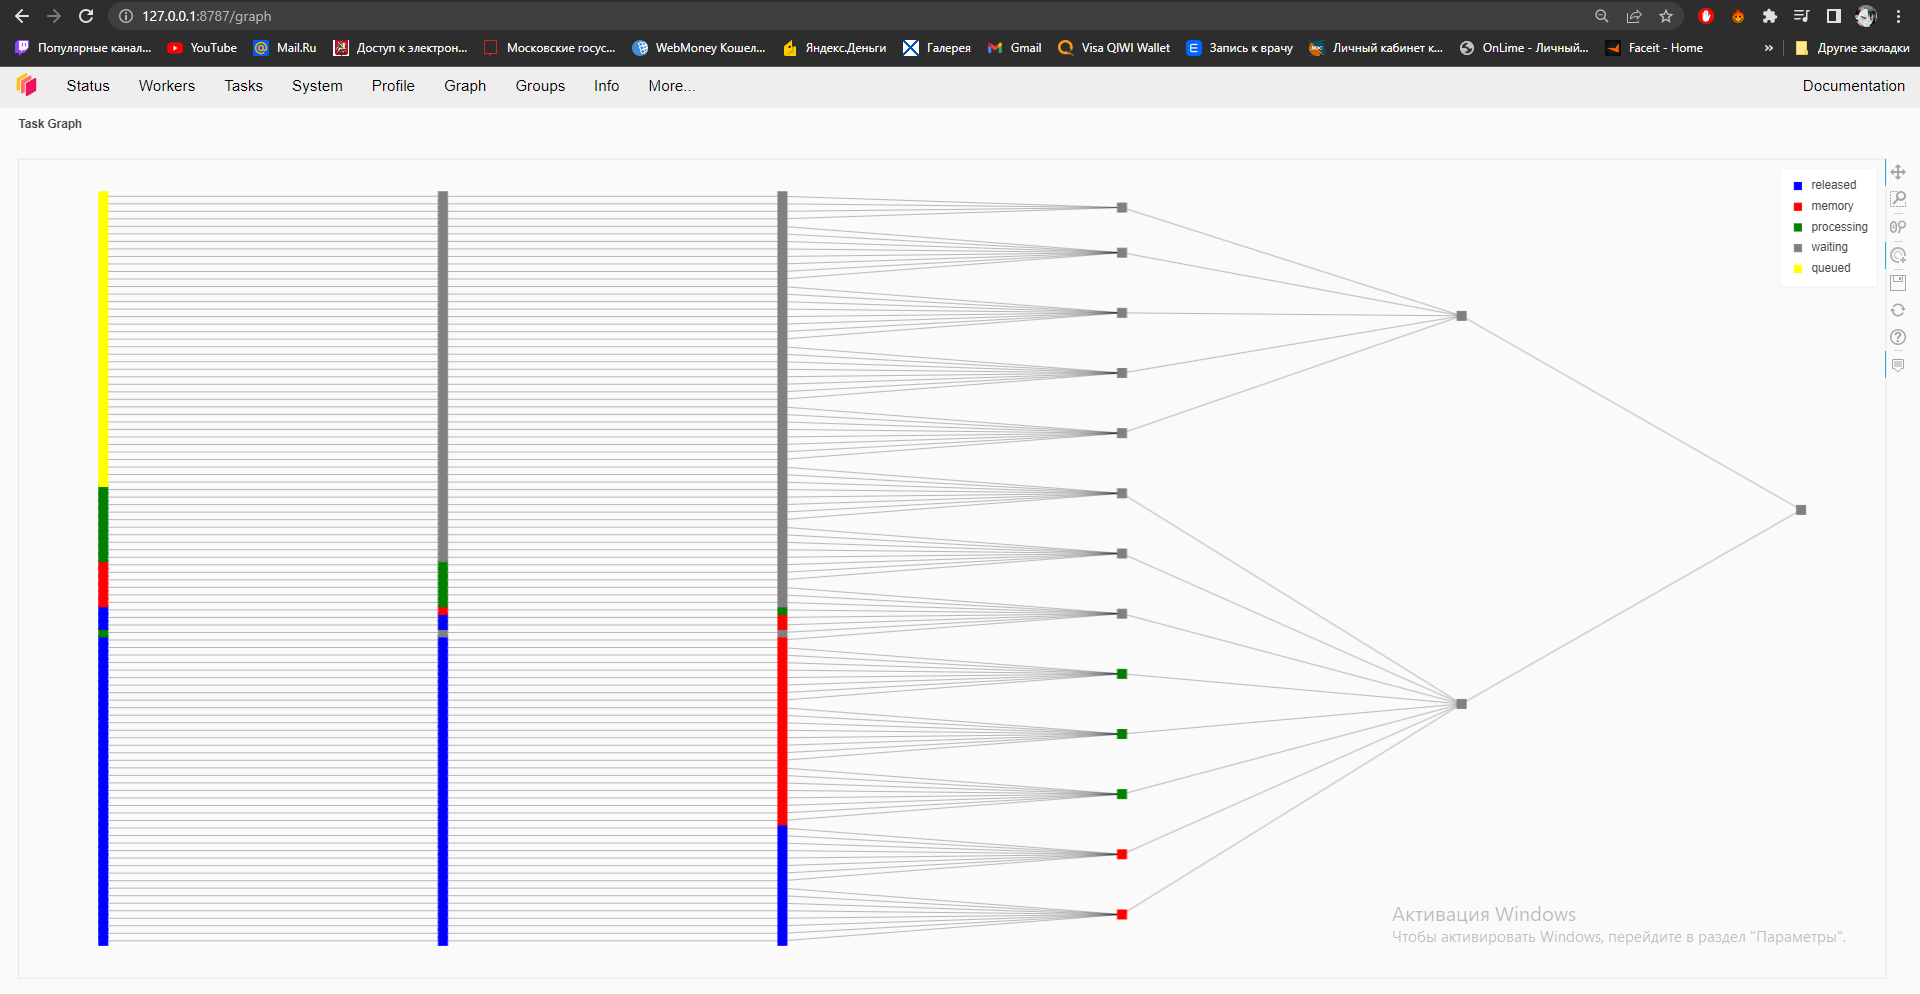

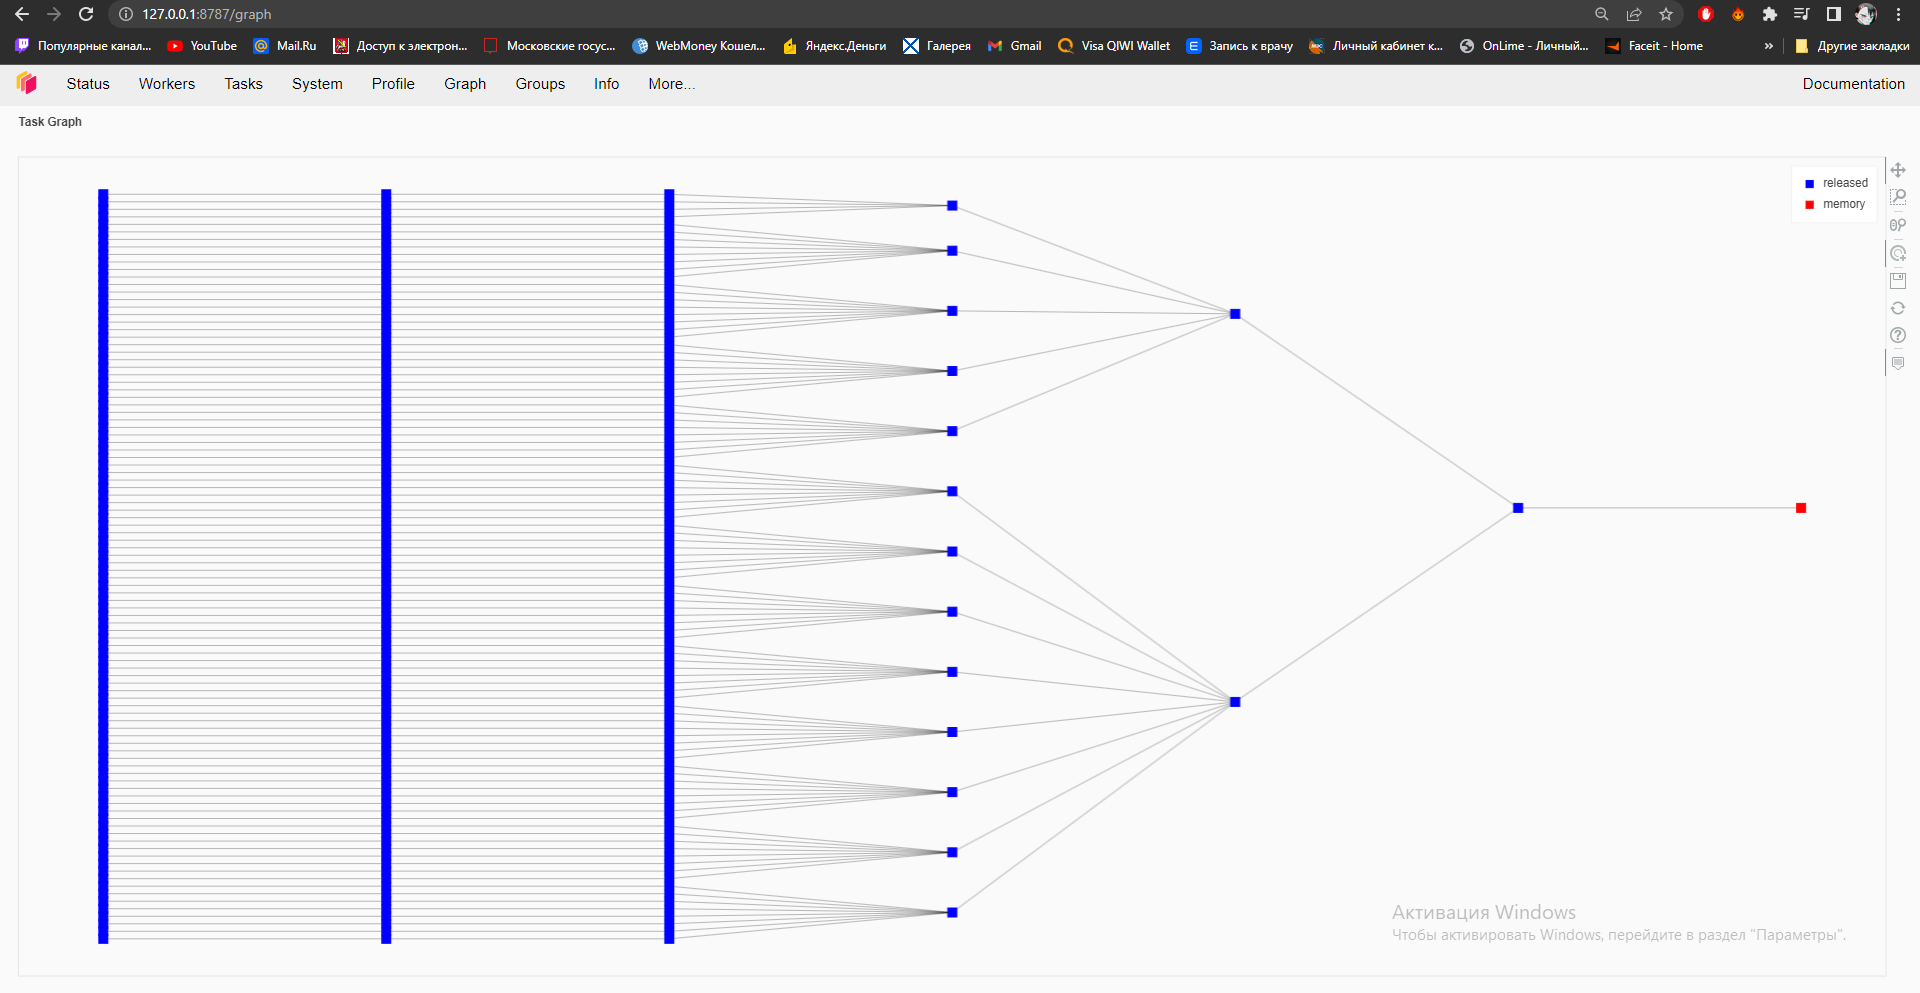

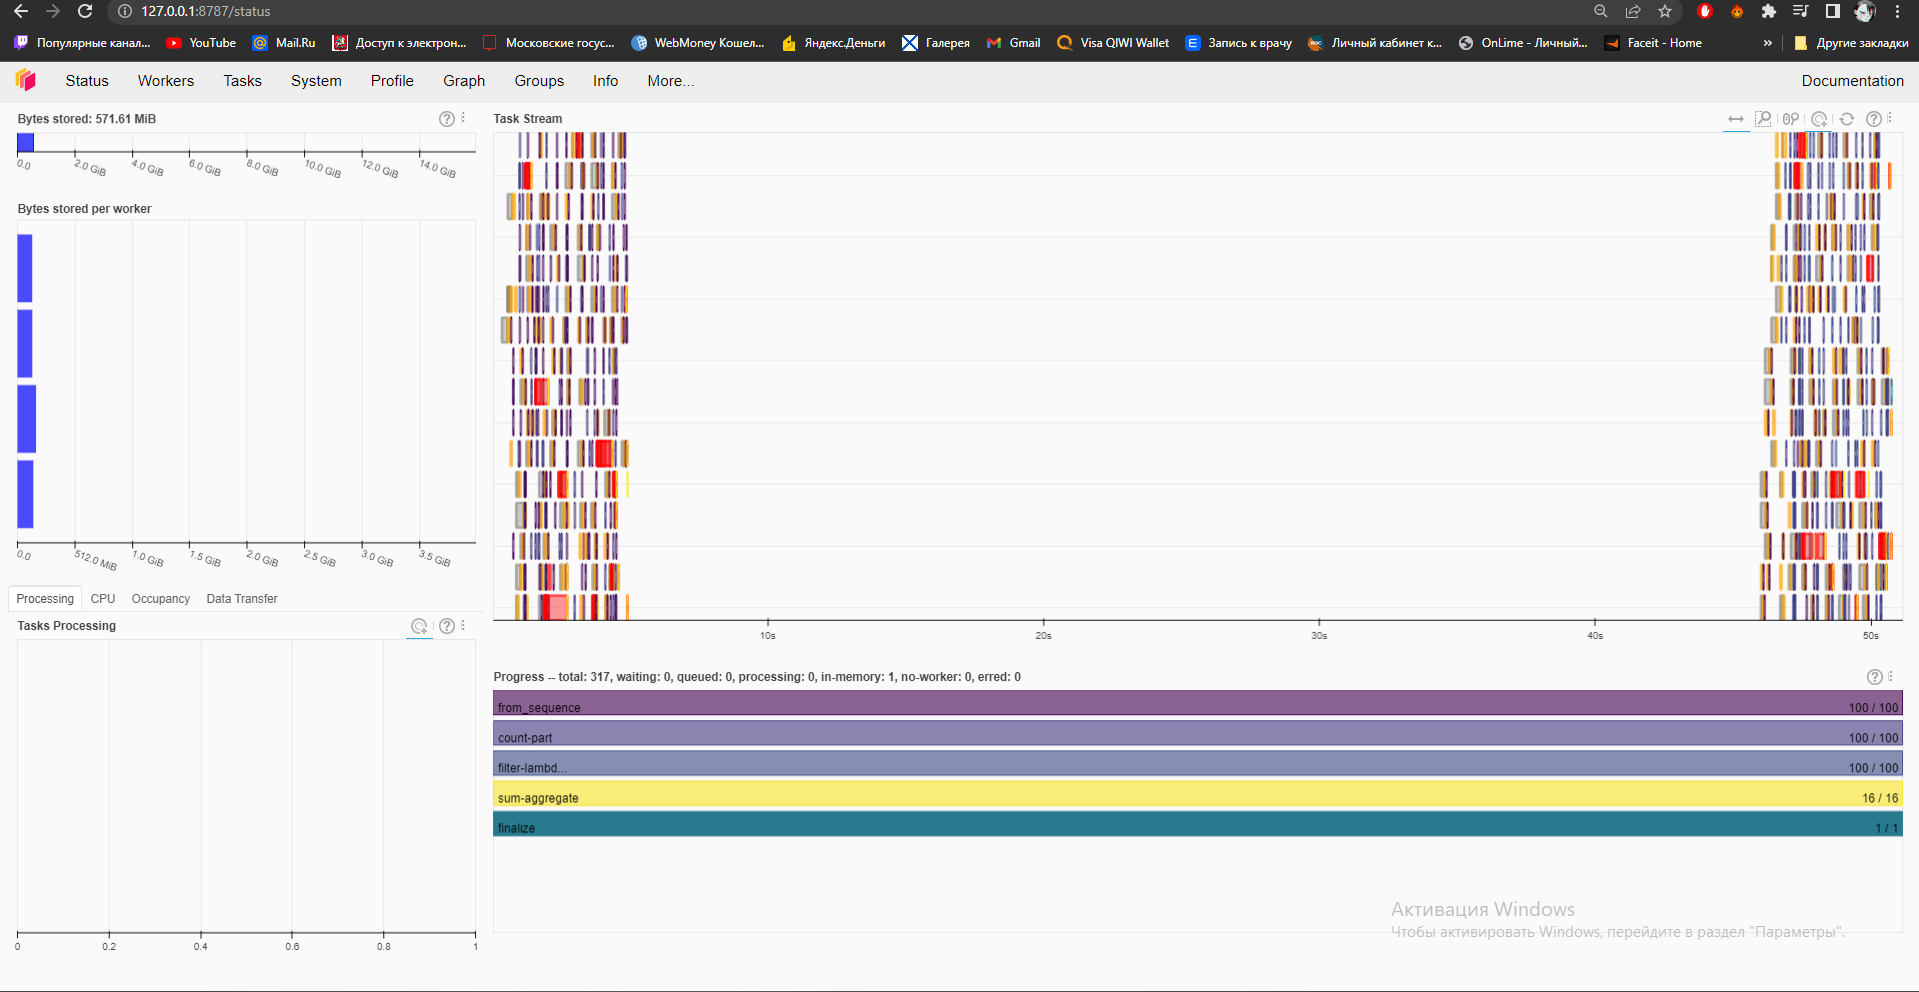

<p class="task" id="9"></p>

9\. Запустите `dask.distributed.Client`. Воспользовавшись `Bag`, полученном в задании 4, создайте `Bag` `young_people`, содержащий записи о людях, которым не более 50 лет. Вычислите и выведите на экран должность (`occupation`), которая встречается чаще всего, а также количество уникальных имен (имя хранится элементе с индексом 0 кортежа под ключом `name`). Выведите на экран эти значения и суммарное время вычисления двух этих значений.

<p class="task" id="10"></p>

10\. Повторите решение задачи 9, предрассчитав значения `young_people` при помощи метода `persist`. Обратите внимание, что при запущенном `Client` метод `Bag.persist` стал неблокирующим. Отследите в дашборде (сделайте и вставьте скриншот) процедуру выполнения метода `persist`. После того, как он закончится, приступайте к дальнейшим вычислениям.

Сравните время выполнения двух решений.